<a href="https://colab.research.google.com/github/cokitodr/TradingBot/blob/main/Tradingbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance webull

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 10.6 MB/s eta 0:00:00
  Created wheel for webull: filename=webull-0.6.1-py3-none-any.whl size=21345 sha256=dd8c47ddae56b967b6b303c6035a85a2865b6b819ee0057d91881c338c76174f
  Stored in directory: /root/.cache/pip/wheels/31/3f/67/1a433b563dc7fc94c18ca2584ce22ca8f0364026f5787a3684
Successfully built webull


In [2]:
import yfinance as yf
from webull import webull

print("Everything works.")

Everything works.


In [3]:
!pip install yfinance pandas numpy matplotlib ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3503d64e53079dc927dac71597d89a066be08f3a2f195516fea7a0085b31c244
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

In [5]:
#Rev 1

ticker = "SPY"
data = yf.download(ticker, start="2020-01-01", end="2024-01-01", auto_adjust=True)
data.columns = data.columns.get_level_values(0)

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,297.699005,297.717350,295.554718,296.480254,59151200
2020-01-03,295.444702,296.571839,294.244268,294.299248,77709700
2020-01-06,296.571899,296.654369,293.566200,293.685332,55653900
2020-01-07,295.737946,296.480198,295.288909,296.003671,40496400
2020-01-08,297.314148,298.532899,295.683022,295.930430,68296000


In [22]:
# EMAs
for period in [5, 9, 13, 20, 50, 200]:
    data[f"EMA_{period}"] = data["Close"].ewm(span=period, adjust=False).mean()

# RSI
data["RSI"] = ta.momentum.rsi(data["Close"], window=14)

# MACD
macd = ta.trend.MACD(data["Close"])
data["MACD"] = macd.macd()
data["MACD_signal"] = macd.macd_signal()

# Volume Moving Average
data["Volume_MA20"] = data["Volume"].rolling(20).mean()

data.dropna(inplace=True)

In [12]:
print(type(data["Close"]))
print(data["Close"].shape)

<class 'pandas.core.series.Series'>
(1006,)


In [15]:
#Define Entry

#data["Buy_Signal"] = (
#    (data["EMA_5"] > data["EMA_9"]) &
#    (data["EMA_9"] > data["EMA_13"]) &
#    (data["RSI"] > 55) &
#    (data["MACD"] > data["MACD_signal"]) &
#    (data["Volume"] > 1.2 * data["Volume_MA20"])
#)

In [16]:
#Define Exit

#data["Sell_Signal"] = (
#    (data["EMA_5"] < data["EMA_13"]) |
#    (data["RSI"] < 45)
#)

In [35]:
# Trend filter
data["Trend"] = data["EMA_20"] > data["EMA_50"]

# RSI above 50
data["RSI_above_50"] = data["RSI"] > 50

# Handle shift safely
rsi_prev = data["RSI_above_50"].shift(1).fillna(False)

# Cross up and cross down
data["RSI_cross_up"] = data["RSI_above_50"] & (~rsi_prev)
data["RSI_cross_down"] = (~data["RSI_above_50"]) & (rsi_prev)

# Final signals
data["Buy_Signal"] = data["Trend"] & data["RSI_cross_up"]
#data["Sell_Signal"] = data["RSI_cross_down"]
data["Sell_Signal"] = data["Close"] < data["EMA_20"]

/tmp/ipython-input-1500071755.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rsi_prev = data["RSI_above_50"].shift(1).fillna(False)


In [36]:
# --- Risk / position sizing parameters ---
capital = 10000       # starting capital
risk_pct = 0.02       # risk 2% per trade
capital_curve = []    # store equity over time
equity = capital

In [50]:
#Built into the code below
# Approximate stop distance = entry price - EMA20
#stop_distance = (data["Close"] - data["EMA_20"]).abs()
#stop_distance = np.maximum((data["Close"] - data["EMA_20"]).abs(), 1)  # e.g., $0.5 minimum
#risk_amount = equity * risk_pct
#data["Position_Size"] = (capital * risk_pct) / stop_distance
#Cap position size to avoid insane leverage
#data["Position_Size"] = np.minimum(risk_amount / stop_distance, equity * 0.1)  # optional cap

In [32]:
#Simulate Trades

#capital = 10000
#position = 0
#entry_price = 0
#equity_curve = []

#for i in range(len(data)):
#    if position == 0 and data["Buy_Signal"].iloc[i]:
#        position = capital / data["Close"].iloc[i]
#        entry_price = data["Close"].iloc[i]
#        capital = 0

#    elif position > 0 and data["Sell_Signal"].iloc[i]:
#        capital = position * data["Close"].iloc[i]
#        position = 0

#    equity = capital if position == 0 else position * data["Close"].iloc[i]
#    equity_curve.append(equity)

#data["Equity"] = equity_curve

In [38]:
#Simulate Trades Rev2

#position = 0
#entry_price = 0
#position_size = 0

#for i in range(len(data)):
#    if position == 0 and data["Buy_Signal"].iloc[i]:
#        position = 1
#        entry_price = data["Close"].iloc[i]
#        position_size = data["Position_Size"].iloc[i]

#    elif position == 1 and data["Sell_Signal"].iloc[i]:
#        exit_price = data["Close"].iloc[i]
#        pnl = (exit_price - entry_price) * position_size
#        equity += pnl
#        position = 0

#    capital_curve.append(equity)

In [51]:
#Simulate Trades Rev3

#position = 0
#entry_price = 0
#position_size = 0

# Track trades
#trade_pnls = []

#for i in range(len(data)):
    # Entry
#    if position == 0 and data["Buy_Signal"].iloc[i]:
#        position = 1
#        entry_price = data["Close"].iloc[i]
#        position_size = data["Position_Size"].iloc[i]

    # Exit
#    elif position == 1 and data["Sell_Signal"].iloc[i]:
#        exit_price = data["Close"].iloc[i]
#        pnl = (exit_price - entry_price) * position_size
#        equity += pnl
#        trade_pnls.append(pnl)
#        position = 0

#    capital_curve.append(equity)

In [78]:
#Simulate Trades Rev4

# Track trades
trade_pnls = []

position = 0
entry_price = 0
position_size = 0
stop_price = 0

for i in range(len(data)):

    low = data["Low"].iloc[i]

    # --- Entry ---
    if position == 0 and data["Buy_Signal"].iloc[i]:
        position = 1
        entry_price = data["Close"].iloc[i]

        # Calculate stop distance (EMA20 exit)
        #stop_distance = max(entry_price - data["EMA_20"].iloc[i], 1)  # minimum $1 stop
        stop_distance = max(data["EMA_20"].iloc[i], entry_price - 1)

        # Risk per trade based on current equity
        risk_amount = equity * risk_pct

        #max_shares = equity / entry_price  # can't buy more than equity allows
        risk_per_share = max(entry_price - stop_distance, 1)

        # Position size capped to 10% of current equity
        #position_size = min(risk_amount / stop_distance, equity * 0.1)
        #position_size = risk_amount / stop_distance
        position_size = risk_amount / risk_per_share

        # CAP: never allow position_size to exceed equity
        #position_size = min(position_size, max_shares)

    # --- Exit ---
    #elif position == 1 and data["Sell_Signal"].iloc[i]:
    #    exit_price = data["Close"].iloc[i]
    #    pnl = (exit_price - entry_price) * position_size
    #    equity += pnl
    #    #equity = max(equity, 0)  # prevents negative equity
    #    trade_pnls.append(pnl)
    #    position = 0

        # --- CHECK STOP ---
    if position == 1:
        if low <= stop_price:
            # Stop hit
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        elif data["Sell_Signal"].iloc[i]:
            # Normal exit
            exit_price = data["Close"].iloc[i]
            pnl = (exit_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0

    capital_curve.append(equity)

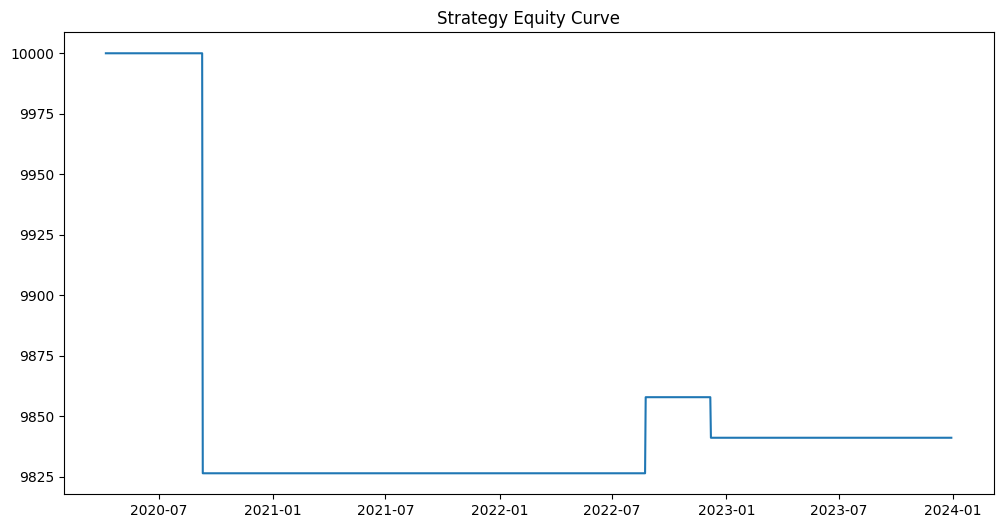

In [40]:
#Simulate Trades

plt.figure(figsize=(12,6))
plt.plot(data.index, data["Equity"])
plt.title("Strategy Equity Curve")
plt.show()

Final equity: -48634.00396364041
Total return: -58634.00396364041


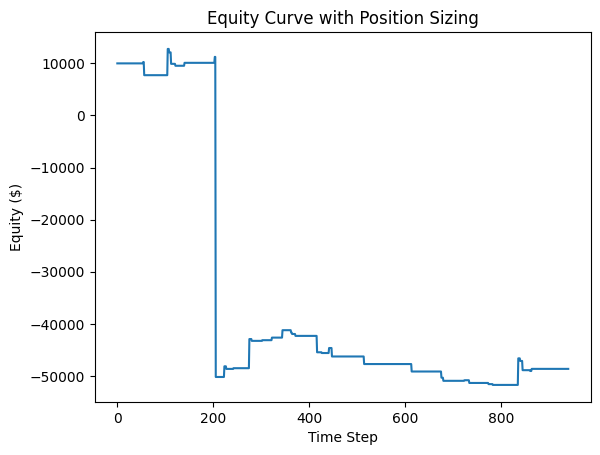

In [39]:
#Simulate trades Rev2

# Final results
print("Final equity:", equity)
print("Total return:", equity - capital)

# Optional: plot equity curve
import matplotlib.pyplot as plt

plt.plot(capital_curve)
plt.title("Equity Curve with Position Sizing")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.show()

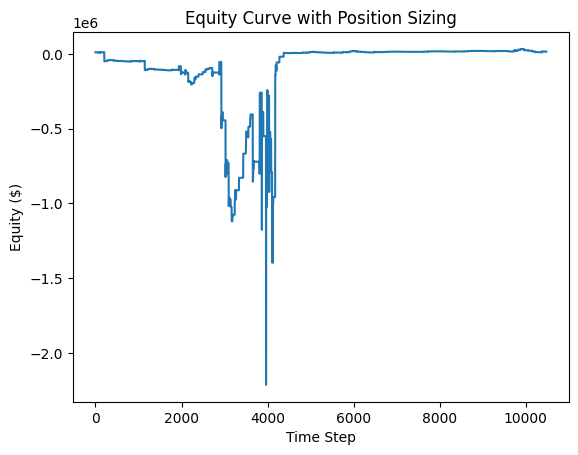

In [79]:
#Simulate Trades Rev3

import matplotlib.pyplot as plt
plt.plot(capital_curve)
plt.title("Equity Curve with Position Sizing")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.show()

In [42]:
#Trade Tracking Rev1

#trades = []
#position = 0
#entry_price = 0

#for i in range(len(data)):
#    if position == 0 and data["Buy_Signal"].iloc[i]:
#        position = 1
#        entry_price = data["Close"].iloc[i]

#    elif position == 1 and data["Sell_Signal"].iloc[i]:
#        exit_price = data["Close"].iloc[i]
#        trades.append((exit_price - entry_price) / entry_price)
#        position = 0

#trades = np.array(trades)

#print("Number of trades:", len(trades))

#if len(trades) > 0:
#    print("Win rate:", np.mean(trades > 0))
#    print("Average win:", np.mean(trades[trades > 0]) if len(trades[trades > 0]) > 0 else 0)
#    print("Average loss:", np.mean(trades[trades <= 0]) if len(trades[trades <= 0]) > 0 else 0)
#    print("Profit factor:", trades[trades > 0].sum() / abs(trades[trades <= 0].sum()) if trades[trades <= 0].sum() != 0 else 0)
#else:
#    print("No trades executed.")

Number of trades: 37
Win rate: 0.3783783783783784
Average win: 0.0329759912264065
Average loss: -0.012533906873883746
Profit factor: 1.6014434036894307


In [80]:
#Trade Tracking Rev2

import numpy as np

trade_pnls = np.array(trade_pnls)
num_trades = len(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins)/num_trades if num_trades > 0 else 0
avg_win = wins.mean() if len(wins) > 0 else 0
avg_loss = losses.mean() if len(losses) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

# --- Outputs ---
print(f"Final equity: {equity}")
print(f"Total return: {equity - capital}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {avg_win:.4f}")
print(f"Average loss: {avg_loss:.4f}")
print(f"Profit factor: {profit_factor:.4f}")

Final equity: 14785.719836295766
Total return: 4785.719836295766
Number of trades: 37
Win rate: 0.27
Average win: 3741.4198
Average loss: -1513.8656
Profit factor: 0.9153


Final equity: 6909.87
Total return: -3090.13
Number of trades: 37
Win rate: 0.19
Average win: 171.1159
Average loss: -142.9313
Profit factor: 0.2793


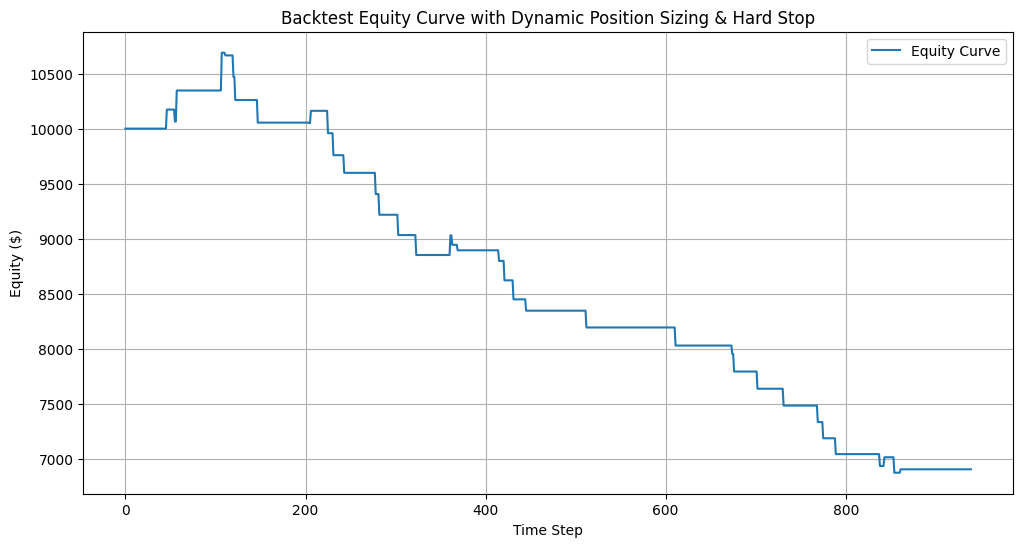

In [81]:
#Full Code Rev2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# --- PARAMETERS ---
# --------------------------
capital = 10000       # starting capital
risk_pct = 0.02       # risk per trade (2%)
equity = capital
capital_curve = []

# --------------------------
# --- PREPARE DATA ---
# --------------------------
# Assuming 'data' is your DataFrame with columns:
# Close, EMA_20, Buy_Signal, Sell_Signal
# Add a Low column if not present (for stop checks)
if "Low" not in data.columns:
    data["Low"] = data["Close"]  # simple assumption; replace with actual lows if available

# --------------------------
# --- BACKTEST LOOP ---
# --------------------------
trade_pnls = []
position = 0
entry_price = 0
position_size = 0
stop_price = 0

for i in range(len(data)):

    price = data["Close"].iloc[i]
    low = data["Low"].iloc[i]

    # --- ENTRY ---
    if position == 0 and data["Buy_Signal"].iloc[i]:
        position = 1
        entry_price = price

        # Hard stop = EMA20, minimum $1 away
        stop_price = max(data["EMA_20"].iloc[i], entry_price - 1)

        # Risk per trade in dollars
        risk_amount = equity * risk_pct

        # Risk per share
        risk_per_share = max(entry_price - stop_price, 1)

        # Position size = number of shares such that max loss = risk_amount
        position_size = risk_amount / risk_per_share

    # --- CHECK STOP ---
    if position == 1:
        if low <= stop_price:
            # Stop hit
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        elif data["Sell_Signal"].iloc[i]:
            # Normal exit
            exit_price = price
            pnl = (exit_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0

    # Track equity curve
    capital_curve.append(equity)

# --------------------------
# --- METRICS ---
# --------------------------
trade_pnls = np.array(trade_pnls)
num_trades = len(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins)/num_trades if num_trades > 0 else 0
avg_win = wins.mean() if len(wins) > 0 else 0
avg_loss = losses.mean() if len(losses) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

# --------------------------
# --- OUTPUT ---
# --------------------------
print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {avg_win:.4f}")
print(f"Average loss: {avg_loss:.4f}")
print(f"Profit factor: {profit_factor:.4f}")

# --------------------------
# --- EQUITY CURVE PLOT ---
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve, label="Equity Curve")
plt.title("Backtest Equity Curve with Dynamic Position Sizing & Hard Stop")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()

Final equity: 5086.44
Total return: -4913.56
Number of trades: 37
Win rate: 0.03
Average win: 16.1682
Average loss: -136.9369
Profit factor: 0.0033


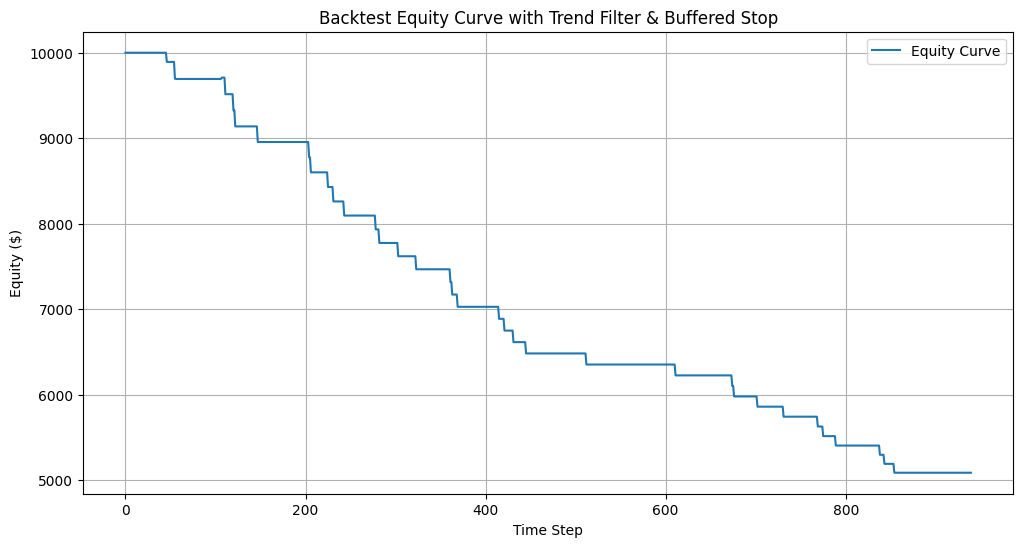

In [82]:
#Full Code Rev3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# --- PARAMETERS ---
# --------------------------
capital = 10000       # starting capital
risk_pct = 0.02       # risk per trade (2%)
equity = capital
capital_curve = []

# --------------------------
# --- PREPARE DATA ---
# --------------------------
# Ensure required columns exist
if "Low" not in data.columns:
    data["Low"] = data["Close"]  # simple placeholder, replace with actual lows if available

# --------------------------
# --- BACKTEST LOOP ---
# --------------------------
trade_pnls = []
position = 0
entry_price = 0
position_size = 0
stop_price = 0

for i in range(len(data)):

    price = data["Close"].iloc[i]
    low = data["Low"].iloc[i]

    # --- ENTRY CONDITION ---
    # Only enter if Buy_Signal AND RSI > 50 AND EMA20 > EMA50 (trend filter)
    if position == 0 and data["Buy_Signal"].iloc[i]:
        if data["RSI"].iloc[i] > 50 and data["EMA_20"].iloc[i] > data["EMA_50"].iloc[i]:
            position = 1
            entry_price = price

            # Hard stop with small buffer (reduces premature stop-outs)
            stop_price = max(data["EMA_20"].iloc[i] - 0.005*entry_price, entry_price - 1)

            # Risk per trade in dollars
            risk_amount = equity * risk_pct

            # Risk per share
            risk_per_share = max(entry_price - stop_price, 1)

            # Position size = number of shares such that max loss = risk_amount
            position_size = risk_amount / risk_per_share

    # --- EXIT CONDITION / STOP CHECK ---
    if position == 1:
        # Stop hit
        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        # Normal exit
        elif data["Sell_Signal"].iloc[i]:
            exit_price = price
            pnl = (exit_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0

    # Track equity over time
    capital_curve.append(equity)

# --------------------------
# --- METRICS ---
# --------------------------
trade_pnls = np.array(trade_pnls)
num_trades = len(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins)/num_trades if num_trades > 0 else 0
avg_win = wins.mean() if len(wins) > 0 else 0
avg_loss = losses.mean() if len(losses) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

# --------------------------
# --- OUTPUT ---
# --------------------------
print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {avg_win:.4f}")
print(f"Average loss: {avg_loss:.4f}")
print(f"Profit factor: {profit_factor:.4f}")

# --------------------------
# --- EQUITY CURVE PLOT ---
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve, label="Equity Curve")
plt.title("Backtest Equity Curve with Trend Filter & Buffered Stop")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()


Final equity: 5086.44
Total return: -4913.56
Number of trades: 37
Win rate: 0.03
Average win: 16.1682
Average loss: -136.9369
Profit factor: 0.0033


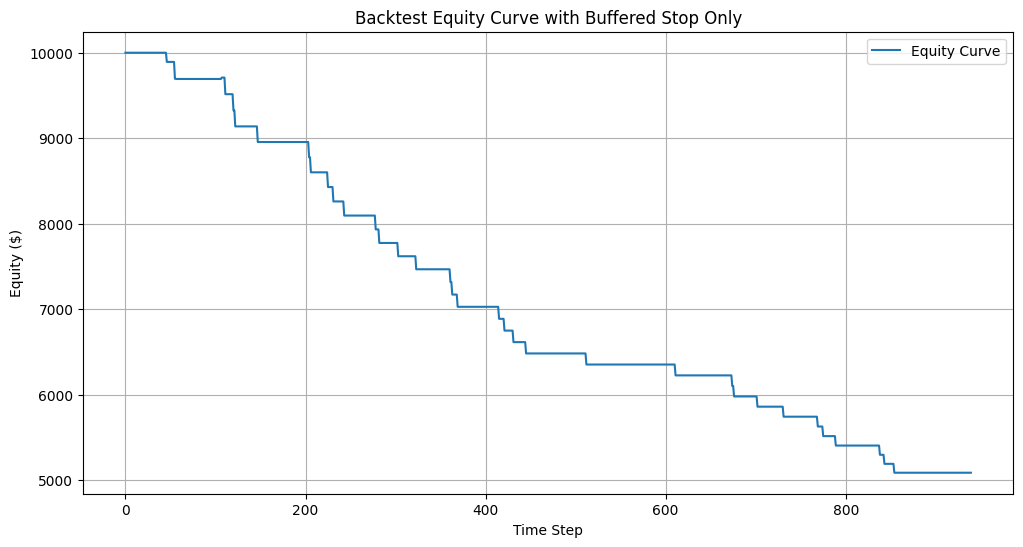

In [86]:
#Full code Rev4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# --- PARAMETERS ---
# --------------------------
capital = 10000       # starting capital
risk_pct = 0.02       # risk per trade (2%)
equity = capital
capital_curve = []

# --------------------------
# --- PREPARE DATA ---
# --------------------------
# Make sure your data has: Close, EMA_20, Buy_Signal, Sell_Signal
# Add a Low column if not present (for stop checks)
if "Low" not in data.columns:
    data["Low"] = data["Close"]  # simple placeholder, replace with actual lows if available

# --------------------------
# --- BACKTEST LOOP ---
# --------------------------
trade_pnls = []
position = 0
entry_price = 0
position_size = 0
stop_price = 0

for i in range(len(data)):

    price = data["Close"].iloc[i]
    low = data["Low"].iloc[i]

    # --- ENTRY CONDITION ---
    if position == 0 and data["Buy_Signal"].iloc[i]:
        position = 1
        entry_price = price

        # Buffered stop: slightly below EMA20, min $1 distance
        stop_price = max(data["EMA_20"].iloc[i] - 0.005*entry_price, entry_price - 1)

        # Risk per trade in dollars
        risk_amount = equity * risk_pct

        # Risk per share
        risk_per_share = max(entry_price - stop_price, 1)

        # Position size = shares such that max loss = risk_amount
        position_size = risk_amount / risk_per_share

    # --- EXIT CONDITION / STOP CHECK ---
    if position == 1:
        # Stop hit
        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        # Normal exit signal
        elif data["Sell_Signal"].iloc[i]:
            exit_price = price
            pnl = (exit_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0

    # Track equity over time
    capital_curve.append(equity)

# --------------------------
# --- METRICS ---
# --------------------------
trade_pnls = np.array(trade_pnls)
num_trades = len(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins)/num_trades if num_trades > 0 else 0
avg_win = wins.mean() if len(wins) > 0 else 0
avg_loss = losses.mean() if len(losses) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

# --------------------------
# --- OUTPUT ---
# --------------------------
print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {avg_win:.4f}")
print(f"Average loss: {avg_loss:.4f}")
print(f"Profit factor: {profit_factor:.4f}")

# --------------------------
# --- EQUITY CURVE PLOT ---
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve, label="Equity Curve")
plt.title("Backtest Equity Curve with Buffered Stop Only")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()

Final equity: 4832.13
Total return: -5167.87
Number of trades: 37
Win rate: 0.00
Average win: 0.0000
Average loss: -139.6721
Profit factor: 0.0000


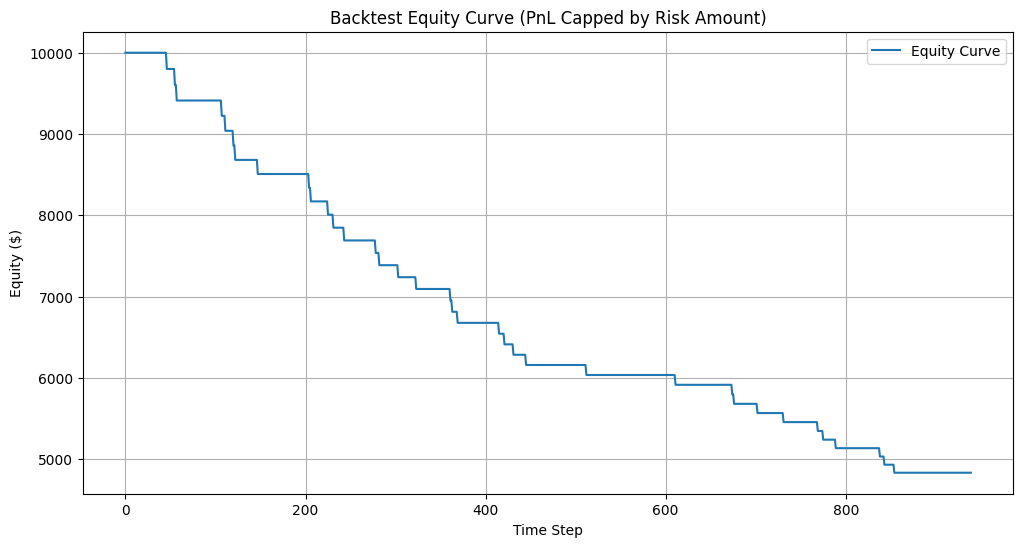

In [87]:
#Full code Rev5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PARAMETERS
capital = 10000
risk_pct = 0.02
equity = capital
capital_curve = []

if "Low" not in data.columns:
    data["Low"] = data["Close"]

trade_pnls = []
position = 0
entry_price = 0
position_size = 0
stop_price = 0

for i in range(len(data)):
    price = data["Close"].iloc[i]
    low = data["Low"].iloc[i]

    # ENTRY
    if position == 0 and data["Buy_Signal"].iloc[i]:
        position = 1
        entry_price = price

        stop_price = max(data["EMA_20"].iloc[i] - 0.005*entry_price, entry_price - 1)

        risk_amount = equity * risk_pct
        risk_per_share = max(entry_price - stop_price, 1)
        position_size = risk_amount / risk_per_share

    # EXIT / STOP
    if position == 1:
        # Stop hit
        if low <= stop_price:
            pnl = -risk_amount  # cap max loss
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        # Normal exit
        elif data["Sell_Signal"].iloc[i]:
            pnl = (price - entry_price) * position_size
            # Optional: cap gain to realistic range if needed
            equity += pnl
            trade_pnls.append(pnl)
            position = 0

    capital_curve.append(equity)

# METRICS
trade_pnls = np.array(trade_pnls)
num_trades = len(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins)/num_trades if num_trades > 0 else 0
avg_win = wins.mean() if len(wins) > 0 else 0
avg_loss = losses.mean() if len(losses) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {avg_win:.4f}")
print(f"Average loss: {avg_loss:.4f}")
print(f"Profit factor: {profit_factor:.4f}")

plt.figure(figsize=(12,6))
plt.plot(capital_curve, label="Equity Curve")
plt.title("Backtest Equity Curve (PnL Capped by Risk Amount)")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()


Final equity: 9561.75
Total return: -438.25
Number of trades: 37
Win rate: 0.19
Average win: 27.2327
Average loss: -20.9628
Profit factor: 0.3031


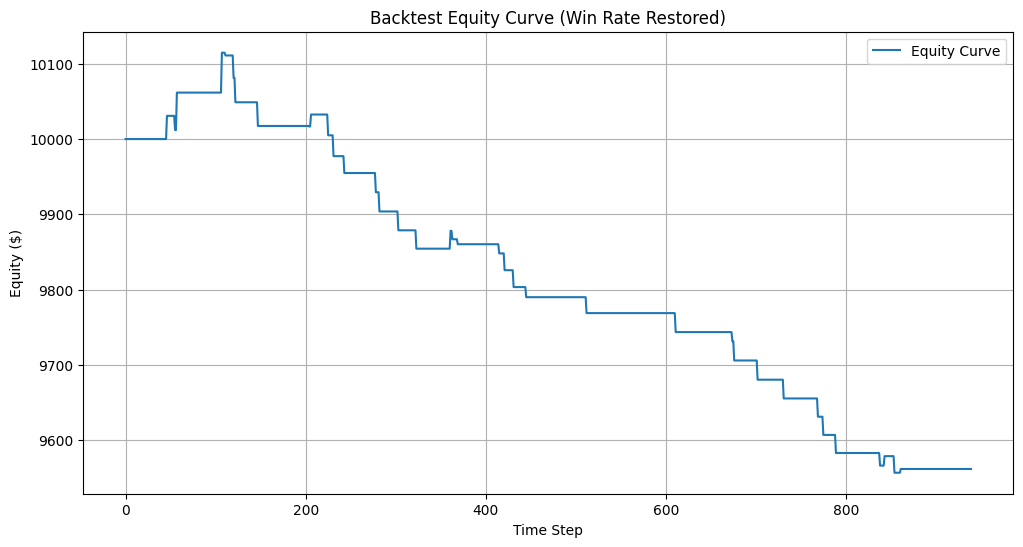

In [89]:
#Full code Rev6

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# --- PARAMETERS ---
# --------------------------
capital = 10000       # starting capital
risk_pct = 0.02       # risk per trade (2% of equity)
equity = capital
capital_curve = []

# Ensure your data has these columns:
# 'Close', 'EMA_20', 'Buy_Signal', 'Sell_Signal', optional 'Low'
if "Low" not in data.columns:
    data["Low"] = data["Close"]  # placeholder if Low is not available

# --------------------------
# --- BACKTEST LOOP ---
# --------------------------
trade_pnls = []
position = 0
entry_price = 0
position_size = 0

for i in range(len(data)):
    price = data["Close"].iloc[i]
    low = data["Low"].iloc[i]

    # --- ENTRY ---
    if position == 0 and data["Buy_Signal"].iloc[i]:
        position = 1
        entry_price = price

        # Stop at EMA20 or $1 minimum distance below entry
        stop_price = max(data["EMA_20"].iloc[i], entry_price - 1)

        # Risk per trade in dollars
        risk_amount = equity * risk_pct

        # Risk per share
        risk_per_share = max(entry_price - stop_price, 1)

        # Position size = shares such that max loss = risk_amount
        position_size = risk_amount / risk_per_share

        # Cap position size to avoid insane leverage
        max_shares = equity / entry_price
        position_size = min(position_size, max_shares)

    # --- EXIT ---
    if position == 1:
        # Stop hit
        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        # Normal exit
        elif data["Sell_Signal"].iloc[i]:
            pnl = (price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0

    capital_curve.append(equity)

# --------------------------
# --- METRICS ---
# --------------------------
trade_pnls = np.array(trade_pnls)
num_trades = len(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins)/num_trades if num_trades > 0 else 0
avg_win = wins.mean() if len(wins) > 0 else 0
avg_loss = losses.mean() if len(losses) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

# --------------------------
# --- OUTPUT ---
# --------------------------
print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {avg_win:.4f}")
print(f"Average loss: {avg_loss:.4f}")
print(f"Profit factor: {profit_factor:.4f}")

# --------------------------
# --- EQUITY CURVE PLOT ---
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve, label="Equity Curve")
plt.title("Backtest Equity Curve (Win Rate Restored)")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()


Final equity: 9561.75
Total return: -438.25
Number of trades: 37
Win rate: 0.19
Average win: 27.2327
Average loss: -20.9628
Profit factor: 0.3031


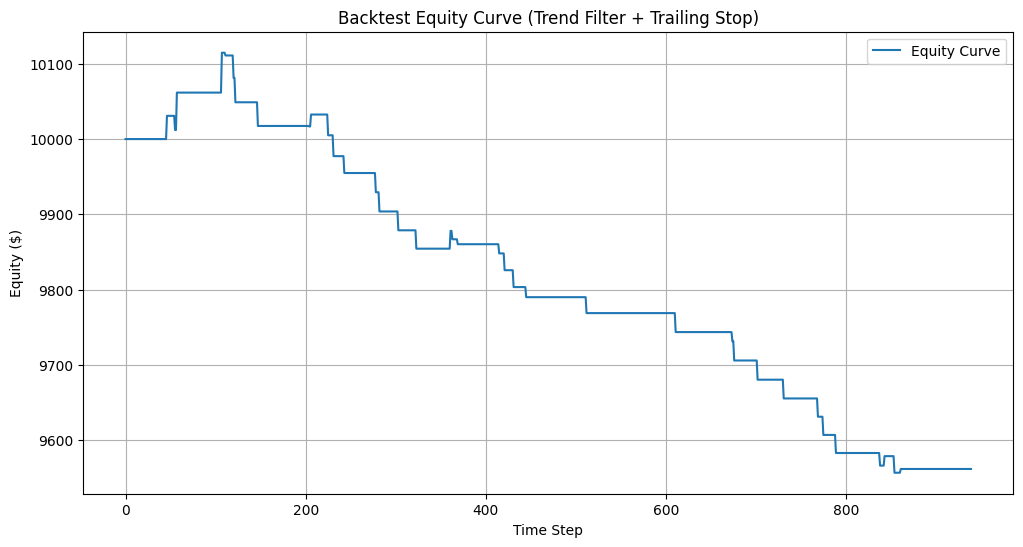

In [91]:
#Full code Rev7

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# --- PARAMETERS ---
# --------------------------
capital = 10000       # starting capital
risk_pct = 0.02       # 2% risk per trade
equity = capital
capital_curve = []

# Ensure required columns
if "Low" not in data.columns:
    data["Low"] = data["Close"]

# --------------------------
# --- BACKTEST LOOP ---
# --------------------------
trade_pnls = []
position = 0
entry_price = 0
position_size = 0
stop_price = 0

for i in range(len(data)):
    price = data["Close"].iloc[i]
    low = data["Low"].iloc[i]

    # --- ENTRY ---
    # Only take trade if buy signal AND price is above EMA50 (trend filter)
    if position == 0 and data["Buy_Signal"].iloc[i] and price > data["EMA_50"].iloc[i]:
        position = 1
        entry_price = price

        # Trailing stop at EMA20 or $1 minimum below entry
        stop_price = max(data["EMA_20"].iloc[i], entry_price - 1)

        # Risk per trade in dollars
        risk_amount = equity * risk_pct

        # Risk per share
        risk_per_share = max(entry_price - stop_price, 1)

        # Number of shares = risk_amount / risk_per_share
        position_size = risk_amount / risk_per_share

        # Cap shares so we never use more capital than we have
        max_shares = equity / entry_price
        position_size = min(position_size, max_shares)

    # --- EXIT ---
    if position == 1:
        # Trailing stop hit
        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        # Sell signal exit
        elif data["Sell_Signal"].iloc[i]:
            pnl = (price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0

        # Update trailing stop if EMA20 rises
        if data["EMA_20"].iloc[i] > stop_price:
            stop_price = data["EMA_20"].iloc[i]

    capital_curve.append(equity)

# --------------------------
# --- METRICS ---
# --------------------------
trade_pnls = np.array(trade_pnls)
num_trades = len(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins)/num_trades if num_trades > 0 else 0
avg_win = wins.mean() if len(wins) > 0 else 0
avg_loss = losses.mean() if len(losses) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

# --------------------------
# --- OUTPUT ---
# --------------------------
print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {avg_win:.4f}")
print(f"Average loss: {avg_loss:.4f}")
print(f"Profit factor: {profit_factor:.4f}")

# --------------------------
# --- EQUITY CURVE PLOT ---
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve, label="Equity Curve")
plt.title("Backtest Equity Curve (Trend Filter + Trailing Stop)")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()


Final equity: 12131.13
Total return: 2131.13
Number of trades: 24
Win rate: 0.50
Average win: 316.5921
Average loss: -138.9978
Profit factor: 2.2777


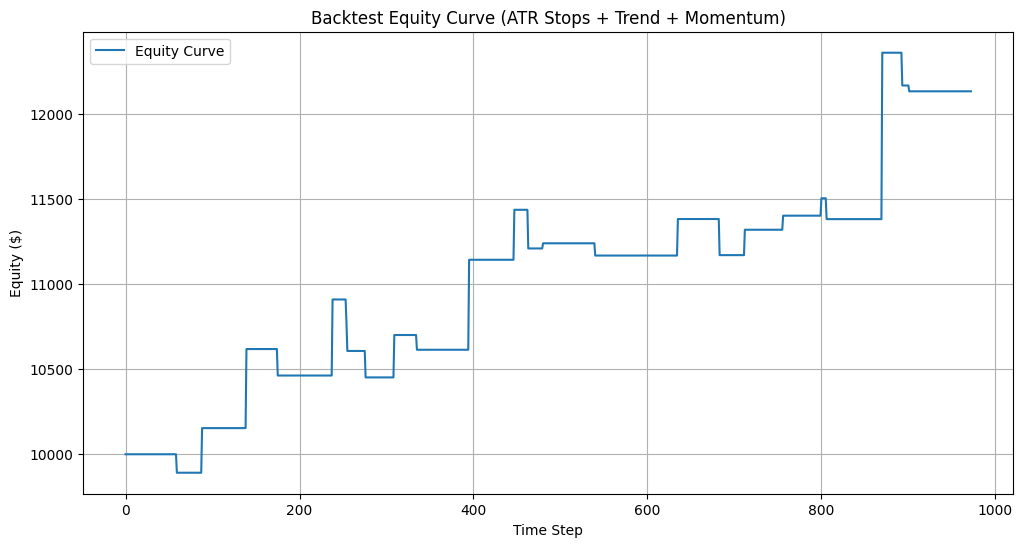

In [13]:
#Full Code Rev8 (best code to date, long only)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# --- PARAMETERS ---
# --------------------------
capital = 10000        # starting capital
risk_pct = 0.02        # 2% risk per trade
equity = capital
capital_curve = []

# Ensure your data has necessary columns
# Required: 'Close', 'High', 'Low'
if "High" not in data.columns:
    data["High"] = data["Close"]
if "Low" not in data.columns:
    data["Low"] = data["Close"]

# --------------------------
# --- INDICATORS ---
# --------------------------
# EMA crossovers
data["EMA_9"] = data["Close"].ewm(span=9, adjust=False).mean()
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()
data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()

# ATR(14)
high_low = data["High"] - data["Low"]
high_close = np.abs(data["High"] - data["Close"].shift(1))
low_close = np.abs(data["Low"] - data["Close"].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data["ATR"] = tr.rolling(14).mean()

# RSI(14)
delta = data["Close"].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
avg_gain = up.rolling(14).mean()
avg_loss = down.rolling(14).mean()
rs = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + rs))

# --------------------------
# --- SIGNALS ---
# --------------------------
# Buy: EMA9 > EMA20 AND RSI > 55 AND price above EMA50
data["Buy_Signal"] = (data["EMA_9"] > data["EMA_20"]) & (data["RSI"] > 55) & (data["Close"] > data["EMA_50"])

# Sell: EMA9 < EMA20 OR RSI < 45
data["Sell_Signal"] = (data["EMA_9"] < data["EMA_20"]) | (data["RSI"] < 45)

# --------------------------
# --- BACKTEST LOOP ---
# --------------------------
trade_pnls = []
position = 0
entry_price = 0
position_size = 0
stop_price = 0

for i in range(len(data)):
    price = data["Close"].iloc[i]
    low = data["Low"].iloc[i]
    atr = data["ATR"].iloc[i]

    # --- ENTRY ---
    if position == 0 and data["Buy_Signal"].iloc[i]:
        position = 1
        entry_price = price

        # ATR-based stop
        stop_price = entry_price - 1.5 * atr

        # Risk per trade in dollars
        risk_amount = equity * risk_pct

        # Shares to risk only risk_amount
        risk_per_share = max(entry_price - stop_price, 1)
        position_size = risk_amount / risk_per_share

        # Cap shares to not exceed equity
        max_shares = equity / entry_price
        position_size = min(position_size, max_shares)

    # --- EXIT ---
    if position == 1:
        # ATR stop hit
        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        # Sell signal exit
        elif data["Sell_Signal"].iloc[i]:
            pnl = (price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            position = 0

        # Update trailing stop if ATR-based stop moves up
        new_stop = entry_price - 1.5 * atr
        if new_stop > stop_price:
            stop_price = new_stop

    capital_curve.append(equity)

# --------------------------
# --- METRICS ---
# --------------------------
trade_pnls = np.array(trade_pnls)
num_trades = len(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins)/num_trades if num_trades > 0 else 0
avg_win = wins.mean() if len(wins) > 0 else 0
avg_loss = losses.mean() if len(losses) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

# --------------------------
# --- OUTPUT ---
# --------------------------
print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {avg_win:.4f}")
print(f"Average loss: {avg_loss:.4f}")
print(f"Profit factor: {profit_factor:.4f}")

# --------------------------
# --- EQUITY CURVE PLOT ---
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve, label="Equity Curve")
plt.title("Backtest Equity Curve (ATR Stops + Trend + Momentum)")
plt.xlabel("Time Step")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()


Final equity: 11766.96
Total return: 1766.96
Number of trades: 87
Win rate: 0.43
Profit factor: 1.2830
Long trades: 52, Avg PnL: 68.18
Short trades: 35, Avg PnL: -50.82


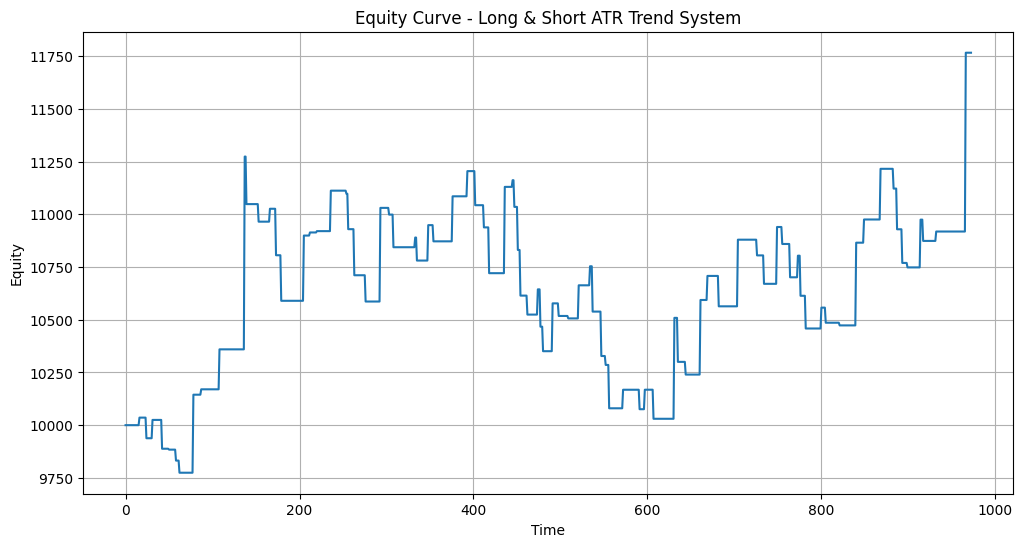

In [12]:
#Full Code Rev9 (Added Short Position Capability)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# PARAMETERS
# --------------------------
capital = 10000
risk_pct = 0.02
equity = capital
capital_curve = []

if "High" not in data.columns:
    data["High"] = data["Close"]
if "Low" not in data.columns:
    data["Low"] = data["Close"]

# --------------------------
# INDICATORS
# --------------------------
data["EMA_9"] = data["Close"].ewm(span=9, adjust=False).mean()
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()
data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()

# ATR(14)
high_low = data["High"] - data["Low"]
high_close = np.abs(data["High"] - data["Close"].shift(1))
low_close = np.abs(data["Low"] - data["Close"].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data["ATR"] = tr.rolling(14).mean()

# RSI(14)
delta = data["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + rs))

# --------------------------
# SIGNALS
# --------------------------
# Long
data["Long_Entry"] = (
    (data["EMA_9"] > data["EMA_20"]) &
    (data["RSI"] > 55) &
    (data["Close"] > data["EMA_50"])
)

data["Long_Exit"] = (
    (data["EMA_9"] < data["EMA_20"]) |
    (data["RSI"] < 50)
)

# Short
data["Short_Entry"] = (
    (data["EMA_9"] < data["EMA_20"]) &
    (data["RSI"] < 45) &
    (data["Close"] < data["EMA_50"])
)

data["Short_Exit"] = (
    (data["EMA_9"] > data["EMA_20"]) |
    (data["RSI"] > 50)
)

# --------------------------
# BACKTEST LOOP
# --------------------------
position = 0   # 1 = long, -1 = short, 0 = flat
entry_price = 0
position_size = 0
stop_price = 0

trade_pnls = []
long_pnls = []
short_pnls = []

for i in range(len(data)):

    price = data["Close"].iloc[i]
    high = data["High"].iloc[i]
    low = data["Low"].iloc[i]
    atr = data["ATR"].iloc[i]

    # ---------------- ENTRY ----------------
    if position == 0:

        # LONG ENTRY
        if data["Long_Entry"].iloc[i]:
            position = 1
            entry_price = price
            stop_price = entry_price - 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(entry_price - stop_price, 1)
            position_size = risk_amount / risk_per_share
            position_size = min(position_size, equity / entry_price)

        # SHORT ENTRY
        elif data["Short_Entry"].iloc[i]:
            position = -1
            entry_price = price
            stop_price = entry_price + 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(stop_price - entry_price, 1)
            position_size = risk_amount / risk_per_share
            position_size = min(position_size, equity / entry_price)

    # ---------------- LONG MANAGEMENT ----------------
    elif position == 1:

        # Stop hit
        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        # Exit signal
        elif data["Long_Exit"].iloc[i]:
            pnl = (price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        # Trailing stop update
        new_stop = price - 1.5 * atr
        if new_stop > stop_price:
            stop_price = new_stop

    # ---------------- SHORT MANAGEMENT ----------------
    elif position == -1:

        # Stop hit
        if high >= stop_price:
            pnl = (entry_price - stop_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        # Exit signal
        elif data["Short_Exit"].iloc[i]:
            pnl = (entry_price - price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        # Trailing stop update
        new_stop = price + 1.5 * atr
        if new_stop < stop_price:
            stop_price = new_stop

    capital_curve.append(equity)

# --------------------------
# METRICS
# --------------------------
trade_pnls = np.array(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins) / len(trade_pnls) if len(trade_pnls) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {len(trade_pnls)}")
print(f"Win rate: {win_rate:.2f}")
print(f"Profit factor: {profit_factor:.4f}")

# Optional: long vs short breakdown
if len(long_pnls) > 0:
    print(f"Long trades: {len(long_pnls)}, Avg PnL: {np.mean(long_pnls):.2f}")

if len(short_pnls) > 0:
    print(f"Short trades: {len(short_pnls)}, Avg PnL: {np.mean(short_pnls):.2f}")

# --------------------------
# EQUITY CURVE
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve)
plt.title("Equity Curve - Long & Short ATR Trend System")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

In [25]:
#Full code Rev10

import pandas as pd
import numpy as np
import yfinance as yf

# ==============================
# DOWNLOAD DATA
# ==============================

ticker = "SPY"
df = yf.download(ticker, start="2020-01-01", end="2024-12-31", auto_adjust=False)

df.columns = df.columns.get_level_values(0)  # flatten multi-index columns
df = df[['Open','High','Low','Close','Volume']]

df.dropna(inplace=True)
df.reset_index(inplace=True)


# ==============================
# INDICATORS
# ==============================

def compute_indicators(df):

    df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # RSI
    delta = df['Close'].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    roll_up = gain.rolling(14).mean()
    roll_down = loss.rolling(14).mean()

    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))

    # ATR
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())

    tr = np.maximum(high_low, np.maximum(high_close, low_close))
    df['ATR'] = pd.Series(tr).rolling(14).mean()

    # ADX
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()

    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), -minus_dm, 0)

    tr_smooth = pd.Series(tr).rolling(14).sum()
    plus_di = 100 * (pd.Series(plus_dm).rolling(14).sum() / tr_smooth)
    minus_di = 100 * (pd.Series(minus_dm).rolling(14).sum() / tr_smooth)

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    df['ADX'] = dx.rolling(14).mean()

    df['VolAvg20'] = df['Volume'].rolling(20).mean()
    df['LL10'] = df['Low'].rolling(10).min()

    return df


# ==============================
# BACKTEST
# ==============================

def backtest(df):

    initial_capital = 10000
    equity = initial_capital
    position = 0
    entry_price = 0
    stop_price = 0

    trades = []
    trade_types = []

    for i in range(200, len(df)-1):

        row = df.iloc[i]
        next_open = df.iloc[i+1]['Open']

        # EXIT
        if position != 0:

            if position == 1:
                if row['Low'] <= stop_price:
                    pnl = stop_price - entry_price
                    equity += pnl
                    trades.append(pnl)
                    trade_types.append("long")
                    position = 0

            elif position == -1:
                if row['High'] >= stop_price:
                    pnl = entry_price - stop_price
                    equity += pnl
                    trades.append(pnl)
                    trade_types.append("short")
                    position = 0

        # ENTRY
        if position == 0:

            long_signal = (
                row['Close'] > row['EMA50'] and
                row['RSI'] > 55 and
                df.iloc[i-1]['RSI'] <= 55 and
                row['ADX'] > 20
            )

            if long_signal:
                position = 1
                entry_price = next_open
                stop_price = entry_price - 2 * row['ATR']
                continue

            short_signal = (
                row['EMA50'] < row['EMA200'] and
                row['Close'] < row['EMA50'] and
                row['RSI'] < 40 and
                row['Close'] <= row['LL10'] and
                row['Volume'] > 1.2 * row['VolAvg20']
            )

            if short_signal:
                position = -1
                entry_price = next_open
                stop_price = entry_price + 2 * row['ATR']
                continue

    trades = np.array(trades)
    wins = trades[trades > 0]
    losses = trades[trades < 0]

    total_return = equity - initial_capital
    win_rate = len(wins) / len(trades) if len(trades) > 0 else 0
    avg_win = wins.mean() if len(wins) > 0 else 0
    avg_loss = losses.mean() if len(losses) > 0 else 0
    profit_factor = abs(wins.sum() / losses.sum()) if len(losses) > 0 else np.inf

    long_trades = [trades[i] for i in range(len(trades)) if trade_types[i] == "long"]
    short_trades = [trades[i] for i in range(len(trades)) if trade_types[i] == "short"]

    print("Final equity:", round(equity,2))
    print("Total return:", round(total_return,2))
    print("Number of trades:", len(trades))
    print("Win rate:", round(win_rate,2))
    print("Average win:", round(avg_win,4))
    print("Average loss:", round(avg_loss,4))
    print("Profit factor:", round(profit_factor,4))

    print("Long trades:", len(long_trades),
          "Avg PnL:", round(np.mean(long_trades),2) if long_trades else 0)

    print("Short trades:", len(short_trades),
          "Avg PnL:", round(np.mean(short_trades),2) if short_trades else 0)


# ==============================
# RUN
# ==============================

df = compute_indicators(df)
backtest(df)


[*********************100%***********************]  1 of 1 completed

Final equity: 9940.73
Total return: -59.27
Number of trades: 6
Win rate: 0.0
Average win: 0
Average loss: -9.8788
Profit factor: 0.0
Long trades: 6 Avg PnL: -9.88
Short trades: 0 Avg PnL: 0


Final equity: 12878.72
Total return: 2878.72
Number of trades: 62
Win rate: 0.53
Average win: 203.76
Average loss: -132.60
Profit factor: 1.7486
Long trades: 51, Avg PnL: 52.52
Short trades: 11, Avg PnL: 18.18


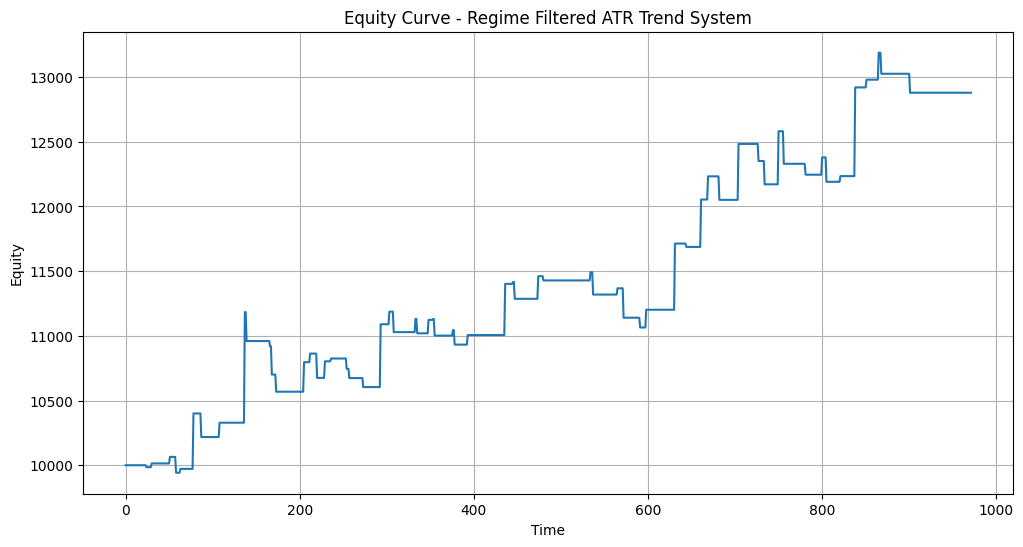

In [27]:
#Full Code Rev11 (best so far 2/11)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# PARAMETERS
# --------------------------
capital = 10000
risk_pct = 0.02
equity = capital
capital_curve = []

data = data.copy()

if "High" not in data.columns:
    data["High"] = data["Close"]
if "Low" not in data.columns:
    data["Low"] = data["Close"]

# --------------------------
# INDICATORS
# --------------------------
data["EMA_9"] = data["Close"].ewm(span=9, adjust=False).mean()
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()
data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()
data["EMA_200"] = data["Close"].ewm(span=200, adjust=False).mean()

# ATR(14)
high_low = data["High"] - data["Low"]
high_close = np.abs(data["High"] - data["Close"].shift(1))
low_close = np.abs(data["Low"] - data["Close"].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data["ATR"] = tr.rolling(14).mean()

# RSI(14)
delta = data["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + rs))

# --------------------------
# SIGNALS (No Lookahead)
# --------------------------

# Long
data["Long_Entry"] = (
    (data["EMA_9"] > data["EMA_20"]) &
    (data["RSI"] > 58) &
    (data["Close"] > data["EMA_50"])
)

data["Long_Exit"] = (
    (data["EMA_9"] < data["EMA_20"]) |
    (data["RSI"] < 52)
)

# Short (Regime Filter)
data["Short_Entry"] = (
    (data["EMA_9"] < data["EMA_20"]) &
    (data["RSI"] < 42) &
    (data["Close"] < data["EMA_50"]) &
    (data["EMA_50"] < data["EMA_200"])
)

data["Short_Exit"] = (
    (data["EMA_9"] > data["EMA_20"]) |
    (data["RSI"] > 48)
)

# --------------------------
# BACKTEST LOOP
# --------------------------
position = 0
entry_price = 0
position_size = 0
stop_price = 0

trade_pnls = []
long_pnls = []
short_pnls = []

for i in range(1, len(data)):

    capital_curve.append(equity)

    price = data["Open"].iloc[i]  # next-bar execution
    high = data["High"].iloc[i]
    low = data["Low"].iloc[i]
    atr = data["ATR"].iloc[i]

    # ================= ENTRY =================
    if position == 0 and not np.isnan(atr):

        # LONG ENTRY (use prior bar signal)
        if data["Long_Entry"].iloc[i-1]:

            position = 1
            entry_price = price
            stop_price = entry_price - 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(entry_price - stop_price, 0.01)
            position_size = risk_amount / risk_per_share
            position_size = min(position_size, equity / entry_price)

        # SHORT ENTRY
        elif data["Short_Entry"].iloc[i-1]:

            position = -1
            entry_price = price
            stop_price = entry_price + 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(stop_price - entry_price, 0.01)
            position_size = risk_amount / risk_per_share
            position_size = min(position_size, equity / entry_price)

    # ================= LONG MANAGEMENT =================
    elif position == 1:

        # Stop hit
        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        # Exit signal
        elif data["Long_Exit"].iloc[i-1]:
            pnl = (price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        # Trailing stop
        else:
            new_stop = price - 1.5 * atr
            if new_stop > stop_price:
                stop_price = new_stop

    # ================= SHORT MANAGEMENT =================
    elif position == -1:

        # Stop hit
        if high >= stop_price:
            pnl = (entry_price - stop_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        # Exit signal
        elif data["Short_Exit"].iloc[i-1]:
            pnl = (entry_price - price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        # Trailing stop
        else:
            new_stop = price + 1.5 * atr
            if new_stop < stop_price:
                stop_price = new_stop

# ================= METRICS =================
trade_pnls = np.array(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins) / len(trade_pnls) if len(trade_pnls) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {len(trade_pnls)}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {wins.mean() if len(wins)>0 else 0:.2f}")
print(f"Average loss: {losses.mean() if len(losses)>0 else 0:.2f}")
print(f"Profit factor: {profit_factor:.4f}")

if len(long_pnls) > 0:
    print(f"Long trades: {len(long_pnls)}, Avg PnL: {np.mean(long_pnls):.2f}")

if len(short_pnls) > 0:
    print(f"Short trades: {len(short_pnls)}, Avg PnL: {np.mean(short_pnls):.2f}")

# ================= EQUITY CURVE =================
plt.figure(figsize=(12,6))
plt.plot(capital_curve)
plt.title("Equity Curve - Regime Filtered ATR Trend System")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

Final equity: 10277.31
Total return: 277.31
Number of trades: 9
Win rate: 0.44
Average win: 202.86
Average loss: -106.83
Profit factor: 1.5192
Long trades: 7, Avg PnL: 59.00
Short trades: 2, Avg PnL: -67.83


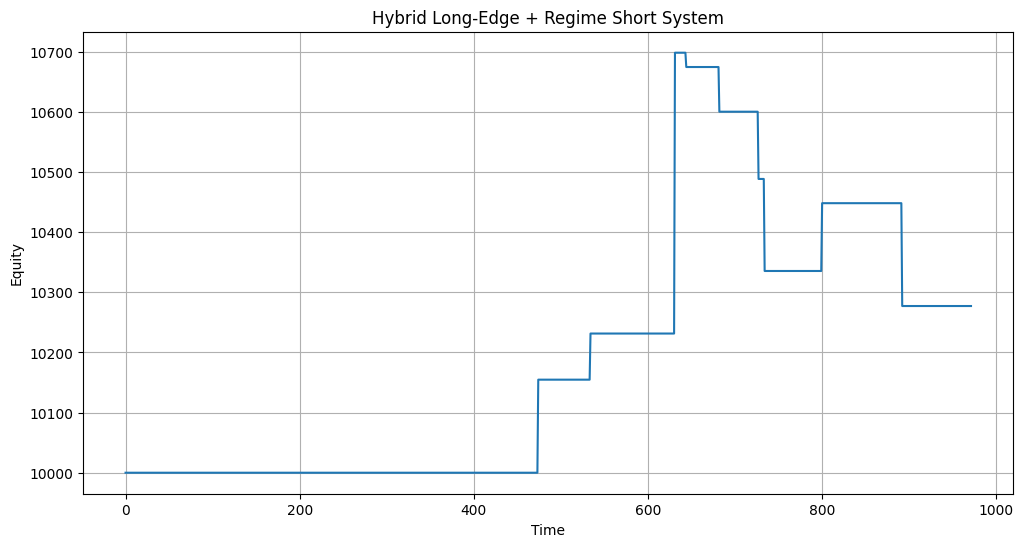

In [29]:
#Full Code Rev11

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# PARAMETERS
# --------------------------
capital = 10000
risk_pct = 0.02
equity = capital
capital_curve = []

data = data.copy()

if "High" not in data.columns:
    data["High"] = data["Close"]
if "Low" not in data.columns:
    data["Low"] = data["Close"]

# --------------------------
# INDICATORS
# --------------------------
data["EMA_9"] = data["Close"].ewm(span=9, adjust=False).mean()
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()
data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()
data["EMA_200"] = data["Close"].ewm(span=200, adjust=False).mean()

# ATR(14)
high_low = data["High"] - data["Low"]
high_close = np.abs(data["High"] - data["Close"].shift(1))
low_close = np.abs(data["Low"] - data["Close"].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data["ATR"] = tr.rolling(14).mean()

# RSI(14)
delta = data["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + rs))

# --------------------------
# SIGNALS
# --------------------------

# === STRONG LONG LOGIC (original edge) ===
data["Long_Entry"] = (
    (data["EMA_9"] > data["EMA_20"]) &
    (data["EMA_9"].shift(1) <= data["EMA_20"].shift(1)) &  # cross
    (data["RSI"] > 55) &
    (data["Close"] > data["EMA_50"])
)

data["Long_Exit"] = (
    (data["EMA_9"] < data["EMA_20"])
)

# === IMPROVED SHORT LOGIC ===
data["Short_Entry"] = (
    (data["EMA_9"] < data["EMA_20"]) &
    (data["EMA_9"].shift(1) >= data["EMA_20"].shift(1)) &  # cross
    (data["RSI"] < 42) &
    (data["Close"] < data["EMA_50"]) &
    (data["EMA_50"] < data["EMA_200"])
)

data["Short_Exit"] = (
    (data["EMA_9"] > data["EMA_20"])
)

# --------------------------
# BACKTEST LOOP
# --------------------------
position = 0
entry_price = 0
position_size = 0
stop_price = 0

trade_pnls = []
long_pnls = []
short_pnls = []

for i in range(1, len(data)):

    capital_curve.append(equity)

    price = data["Open"].iloc[i]
    high = data["High"].iloc[i]
    low = data["Low"].iloc[i]
    atr = data["ATR"].iloc[i]

    if np.isnan(atr):
        continue

    # ENTRY
    if position == 0:

        if data["Long_Entry"].iloc[i-1]:

            position = 1
            entry_price = price
            stop_price = entry_price - 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(entry_price - stop_price, 0.01)
            position_size = min(risk_amount / risk_per_share, equity / entry_price)

        elif data["Short_Entry"].iloc[i-1]:

            position = -1
            entry_price = price
            stop_price = entry_price + 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(stop_price - entry_price, 0.01)
            position_size = min(risk_amount / risk_per_share, equity / entry_price)

    # LONG MANAGEMENT
    elif position == 1:

        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        elif data["Long_Exit"].iloc[i-1]:
            pnl = (price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        else:
            new_stop = price - 1.5 * atr
            if new_stop > stop_price:
                stop_price = new_stop

    # SHORT MANAGEMENT
    elif position == -1:

        if high >= stop_price:
            pnl = (entry_price - stop_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        elif data["Short_Exit"].iloc[i-1]:
            pnl = (entry_price - price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        else:
            new_stop = price + 1.5 * atr
            if new_stop < stop_price:
                stop_price = new_stop

# --------------------------
# METRICS
# --------------------------
trade_pnls = np.array(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins) / len(trade_pnls) if len(trade_pnls) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {len(trade_pnls)}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {wins.mean() if len(wins)>0 else 0:.2f}")
print(f"Average loss: {losses.mean() if len(losses)>0 else 0:.2f}")
print(f"Profit factor: {profit_factor:.4f}")

if len(long_pnls) > 0:
    print(f"Long trades: {len(long_pnls)}, Avg PnL: {np.mean(long_pnls):.2f}")

if len(short_pnls) > 0:
    print(f"Short trades: {len(short_pnls)}, Avg PnL: {np.mean(short_pnls):.2f}")

# --------------------------
# EQUITY CURVE
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve)
plt.title("Hybrid Long-Edge + Regime Short System")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True)
plt.show()


Final equity: 12202.83
Total return: 2202.83
Number of trades: 71
Win rate: 0.51
Average win: 185.43
Average loss: -127.79
Profit factor: 1.4925
Long trades: 60, Avg PnL: 33.67
Short trades: 11, Avg PnL: 16.59


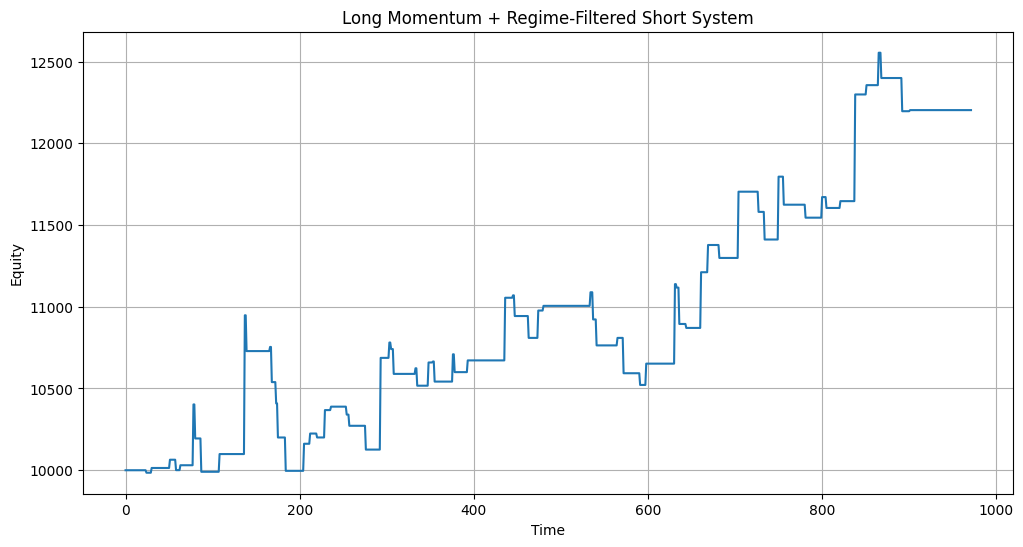

In [30]:
#Full code Rev12

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# PARAMETERS
# --------------------------
capital = 10000
risk_pct = 0.02
equity = capital
capital_curve = []

data = data.copy()

if "High" not in data.columns:
    data["High"] = data["Close"]
if "Low" not in data.columns:
    data["Low"] = data["Close"]

# --------------------------
# INDICATORS
# --------------------------
data["EMA_9"] = data["Close"].ewm(span=9, adjust=False).mean()
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()
data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()
data["EMA_200"] = data["Close"].ewm(span=200, adjust=False).mean()

# ATR(14)
high_low = data["High"] - data["Low"]
high_close = np.abs(data["High"] - data["Close"].shift(1))
low_close = np.abs(data["Low"] - data["Close"].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data["ATR"] = tr.rolling(14).mean()

# RSI(14)
delta = data["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + rs))

# --------------------------
# SIGNALS (State-Based)
# --------------------------

# ORIGINAL STRONG LONG LOGIC
data["Long_Entry"] = (
    (data["EMA_9"] > data["EMA_20"]) &
    (data["RSI"] > 55) &
    (data["Close"] > data["EMA_50"])
)

data["Long_Exit"] = (
    (data["EMA_9"] < data["EMA_20"]) |
    (data["RSI"] < 50)
)

# IMPROVED SHORT LOGIC WITH REGIME FILTER
data["Short_Entry"] = (
    (data["EMA_9"] < data["EMA_20"]) &
    (data["RSI"] < 42) &
    (data["Close"] < data["EMA_50"]) &
    (data["EMA_50"] < data["EMA_200"])
)

data["Short_Exit"] = (
    (data["EMA_9"] > data["EMA_20"]) |
    (data["RSI"] > 48)
)

# --------------------------
# BACKTEST LOOP
# --------------------------
position = 0
entry_price = 0
position_size = 0
stop_price = 0

trade_pnls = []
long_pnls = []
short_pnls = []

for i in range(1, len(data)):

    capital_curve.append(equity)

    price = data["Open"].iloc[i]
    high = data["High"].iloc[i]
    low = data["Low"].iloc[i]
    atr = data["ATR"].iloc[i]

    if np.isnan(atr):
        continue

    # ENTRY
    if position == 0:

        if data["Long_Entry"].iloc[i-1]:

            position = 1
            entry_price = price
            stop_price = entry_price - 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(entry_price - stop_price, 0.01)
            position_size = min(risk_amount / risk_per_share, equity / entry_price)

        elif data["Short_Entry"].iloc[i-1]:

            position = -1
            entry_price = price
            stop_price = entry_price + 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(stop_price - entry_price, 0.01)
            position_size = min(risk_amount / risk_per_share, equity / entry_price)

    # LONG MANAGEMENT
    elif position == 1:

        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        elif data["Long_Exit"].iloc[i-1]:
            pnl = (price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        else:
            new_stop = price - 1.5 * atr
            if new_stop > stop_price:
                stop_price = new_stop

    # SHORT MANAGEMENT
    elif position == -1:

        if high >= stop_price:
            pnl = (entry_price - stop_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        elif data["Short_Exit"].iloc[i-1]:
            pnl = (entry_price - price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        else:
            new_stop = price + 1.5 * atr
            if new_stop < stop_price:
                stop_price = new_stop

# --------------------------
# METRICS
# --------------------------
trade_pnls = np.array(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins) / len(trade_pnls) if len(trade_pnls) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {len(trade_pnls)}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {wins.mean() if len(wins)>0 else 0:.2f}")
print(f"Average loss: {losses.mean() if len(losses)>0 else 0:.2f}")
print(f"Profit factor: {profit_factor:.4f}")

if len(long_pnls) > 0:
    print(f"Long trades: {len(long_pnls)}, Avg PnL: {np.mean(long_pnls):.2f}")

if len(short_pnls) > 0:
    print(f"Short trades: {len(short_pnls)}, Avg PnL: {np.mean(short_pnls):.2f}")

# --------------------------
# EQUITY CURVE
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(capital_curve)
plt.title("Long Momentum + Regime-Filtered Short System")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True)
plt.show()


Final equity: 11852.37
Total return: 1852.37
Number of trades: 93
Win rate: 0.42
Average win: 223.08
Average loss: -126.81
Profit factor: 1.2705
Long trades: 55, Avg PnL: 61.37
Short trades: 38, Avg PnL: -40.08


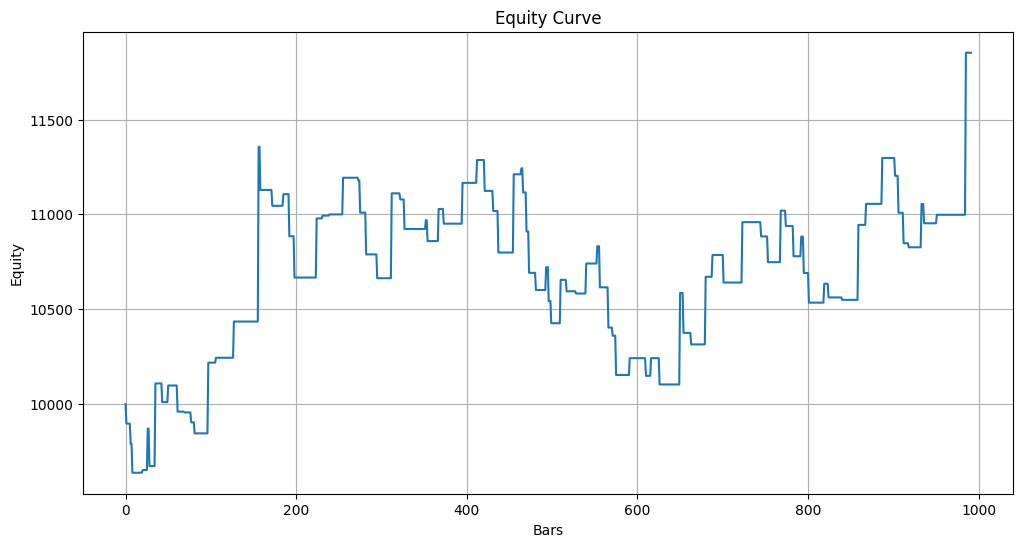

In [6]:
#Full Code Rev13

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================
# CLEAN DATA STRUCTURE
# =============================

# If columns are MultiIndex (from yfinance), flatten them
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Keep only needed columns
data = data[["Open", "High", "Low", "Close"]].copy()

# Force numeric + 1D series
for col in ["Open", "High", "Low", "Close"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Drop missing rows
data.dropna(inplace=True)

# =============================
# PARAMETERS
# =============================

capital = 10000
risk_pct = 0.02
equity = capital
capital_curve = []

# =============================
# INDICATORS
# =============================

data["EMA_9"] = data["Close"].ewm(span=9, adjust=False).mean()
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()
data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()

# ATR(14)
high_low = data["High"] - data["Low"]
high_close = (data["High"] - data["Close"].shift(1)).abs()
low_close = (data["Low"] - data["Close"].shift(1)).abs()

tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data["ATR"] = tr.rolling(14).mean()

# RSI(14)
delta = data["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + rs))

# Drop NaNs from indicators
data.dropna(inplace=True)

# =============================
# SIGNALS
# =============================

# LONG (original strong logic)
data["Long_Entry"] = (
    (data["EMA_9"] > data["EMA_20"]) &
    (data["RSI"] > 55) &
    (data["Close"] > data["EMA_50"])
)

data["Long_Exit"] = (
    (data["EMA_9"] < data["EMA_20"]) |
    (data["RSI"] < 50)
)

# SHORT (selective)
data["Short_Entry"] = (
    (data["EMA_9"] < data["EMA_20"]) &
    (data["RSI"] < 45) &
    (data["Close"] < data["EMA_50"])
)

data["Short_Exit"] = (
    (data["EMA_9"] > data["EMA_20"]) |
    (data["RSI"] > 50)
)

# =============================
# BACKTEST
# =============================

position = 0
entry_price = 0
position_size = 0
stop_price = 0

trade_pnls = []
long_pnls = []
short_pnls = []

for i in range(len(data)):

    price = data["Close"].iloc[i]
    high = data["High"].iloc[i]
    low = data["Low"].iloc[i]
    atr = data["ATR"].iloc[i]

    # ENTRY
    if position == 0:

        # LONG
        if data["Long_Entry"].iloc[i]:
            position = 1
            entry_price = price
            stop_price = entry_price - 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(entry_price - stop_price, 0.01)
            position_size = min(risk_amount / risk_per_share, equity / entry_price)

        # SHORT
        elif data["Short_Entry"].iloc[i]:
            position = -1
            entry_price = price
            stop_price = entry_price + 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(stop_price - entry_price, 0.01)
            position_size = min(risk_amount / risk_per_share, equity / entry_price)

    # LONG MANAGEMENT
    elif position == 1:

        if low <= stop_price:
            pnl = (stop_price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        elif data["Long_Exit"].iloc[i]:
            pnl = (price - entry_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            long_pnls.append(pnl)
            position = 0

        else:
            new_stop = price - 1.5 * atr
            if new_stop > stop_price:
                stop_price = new_stop

    # SHORT MANAGEMENT
    elif position == -1:

        if high >= stop_price:
            pnl = (entry_price - stop_price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        elif data["Short_Exit"].iloc[i]:
            pnl = (entry_price - price) * position_size
            equity += pnl
            trade_pnls.append(pnl)
            short_pnls.append(pnl)
            position = 0

        else:
            new_stop = price + 1.5 * atr
            if new_stop < stop_price:
                stop_price = new_stop

    capital_curve.append(equity)

# =============================
# METRICS
# =============================

trade_pnls = np.array(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins) / len(trade_pnls) if len(trade_pnls) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {len(trade_pnls)}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {wins.mean() if len(wins)>0 else 0:.2f}")
print(f"Average loss: {losses.mean() if len(losses)>0 else 0:.2f}")
print(f"Profit factor: {profit_factor:.4f}")

if len(long_pnls) > 0:
    print(f"Long trades: {len(long_pnls)}, Avg PnL: {np.mean(long_pnls):.2f}")

if len(short_pnls) > 0:
    print(f"Short trades: {len(short_pnls)}, Avg PnL: {np.mean(short_pnls):.2f}")

# =============================
# EQUITY CURVE
# =============================

plt.figure(figsize=(12,6))
plt.plot(capital_curve)
plt.title("Equity Curve")
plt.xlabel("Bars")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


Final equity: 10253.24
Total return: 253.24
Number of trades: 126
Win rate: 0.37
Average win: 181.51
Average loss: -104.78
Profit factor: 1.0306
Long trades: 79, Avg PnL: 36.86
Short trades: 47, Avg PnL: -56.57


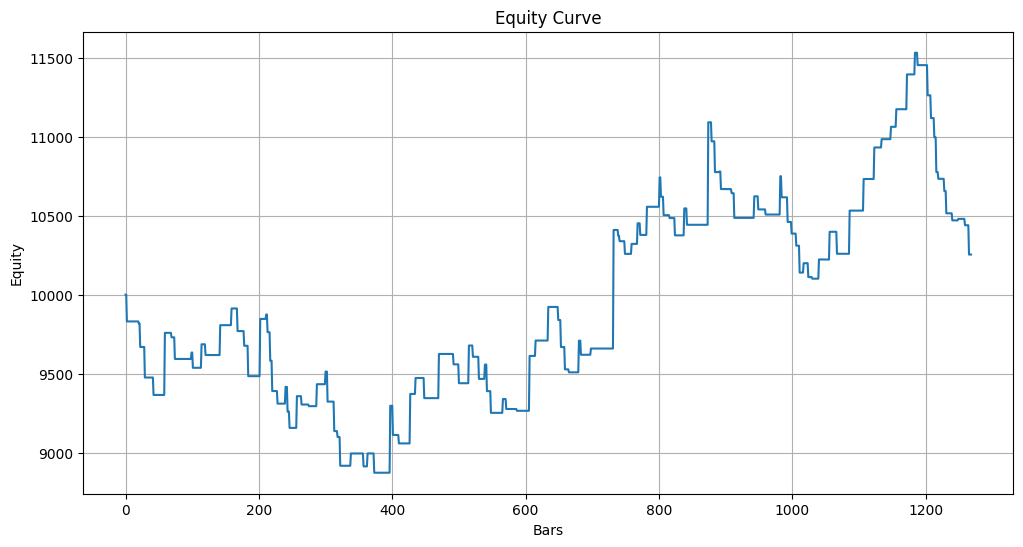

    Side Entry_Date  Exit_Date  Entry_Price  Exit_Price         PnL
0   Long 2021-01-25 2021-01-27   358.818970  352.721031 -169.944711
1   Long 2021-02-04 2021-02-23   360.499176  359.973857  -13.293313
2   Long 2021-02-24 2021-02-25   365.708008  360.183153 -148.304609
3  Short 2021-03-04 2021-03-08   351.640472  360.271809 -193.369147
4   Long 2021-03-12 2021-03-25   367.845673  361.658427 -110.273256


In [23]:
#Full code Rev14 (top 5 trades exported)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# =============================
# DOWNLOAD DATA (NO API KEY)
# =============================

symbol = "SPY"
data = yf.download(symbol, start="2021-01-01", auto_adjust=True)

# =============================
# CLEAN DATA STRUCTURE
# =============================

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[["Open", "High", "Low", "Close"]].copy()

for col in ["Open", "High", "Low", "Close"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data.dropna(inplace=True)

# =============================
# PARAMETERS
# =============================

capital = 10000
risk_pct = 0.02
equity = capital
capital_curve = []

# =============================
# INDICATORS
# =============================

data["EMA_9"] = data["Close"].ewm(span=9, adjust=False).mean()
data["EMA_20"] = data["Close"].ewm(span=20, adjust=False).mean()
data["EMA_50"] = data["Close"].ewm(span=50, adjust=False).mean()

high_low = data["High"] - data["Low"]
high_close = (data["High"] - data["Close"].shift(1)).abs()
low_close = (data["Low"] - data["Close"].shift(1)).abs()

tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data["ATR"] = tr.rolling(14).mean()

delta = data["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + rs))

data.dropna(inplace=True)

# =============================
# SIGNALS
# =============================

data["Long_Entry"] = (
    (data["EMA_9"] > data["EMA_20"]) &
    (data["RSI"] > 55) &
    (data["Close"] > data["EMA_50"])
)

data["Long_Exit"] = (
    (data["EMA_9"] < data["EMA_20"]) |
    (data["RSI"] < 50)
)

data["Short_Entry"] = (
    (data["EMA_9"] < data["EMA_20"]) &
    (data["RSI"] < 45) &
    (data["Close"] < data["EMA_50"])
)

data["Short_Exit"] = (
    (data["EMA_9"] > data["EMA_20"]) |
    (data["RSI"] > 50)
)

# =============================
# BACKTEST
# =============================

position = 0
entry_price = 0
position_size = 0
stop_price = 0

trade_pnls = []
long_pnls = []
short_pnls = []
trade_log = []

for i in range(len(data)):

    price = data["Close"].iloc[i]
    high = data["High"].iloc[i]
    low = data["Low"].iloc[i]
    atr = data["ATR"].iloc[i]
    date = data.index[i]

    # ENTRY
    if position == 0:

        if data["Long_Entry"].iloc[i]:
            position = 1
            entry_price = price
            stop_price = entry_price - 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(entry_price - stop_price, 0.01)
            position_size = min(risk_amount / risk_per_share, equity / entry_price)

            entry_date = date

        elif data["Short_Entry"].iloc[i]:
            position = -1
            entry_price = price
            stop_price = entry_price + 1.5 * atr

            risk_amount = equity * risk_pct
            risk_per_share = max(stop_price - entry_price, 0.01)
            position_size = min(risk_amount / risk_per_share, equity / entry_price)

            entry_date = date

    # LONG MANAGEMENT
    elif position == 1:

        if low <= stop_price:
            exit_price = stop_price
            pnl = (exit_price - entry_price) * position_size
            equity += pnl

            trade_pnls.append(pnl)
            long_pnls.append(pnl)

            trade_log.append({
                "Side": "Long",
                "Entry_Date": entry_date,
                "Exit_Date": date,
                "Entry_Price": entry_price,
                "Exit_Price": exit_price,
                "PnL": pnl
            })

            position = 0

        elif data["Long_Exit"].iloc[i]:
            exit_price = price
            pnl = (exit_price - entry_price) * position_size
            equity += pnl

            trade_pnls.append(pnl)
            long_pnls.append(pnl)

            trade_log.append({
                "Side": "Long",
                "Entry_Date": entry_date,
                "Exit_Date": date,
                "Entry_Price": entry_price,
                "Exit_Price": exit_price,
                "PnL": pnl
            })

            position = 0

        else:
            new_stop = price - 1.5 * atr
            if new_stop > stop_price:
                stop_price = new_stop

    # SHORT MANAGEMENT
    elif position == -1:

        if high >= stop_price:
            exit_price = stop_price
            pnl = (entry_price - exit_price) * position_size
            equity += pnl

            trade_pnls.append(pnl)
            short_pnls.append(pnl)

            trade_log.append({
                "Side": "Short",
                "Entry_Date": entry_date,
                "Exit_Date": date,
                "Entry_Price": entry_price,
                "Exit_Price": exit_price,
                "PnL": pnl
            })

            position = 0

        elif data["Short_Exit"].iloc[i]:
            exit_price = price
            pnl = (entry_price - exit_price) * position_size
            equity += pnl

            trade_pnls.append(pnl)
            short_pnls.append(pnl)

            trade_log.append({
                "Side": "Short",
                "Entry_Date": entry_date,
                "Exit_Date": date,
                "Entry_Price": entry_price,
                "Exit_Price": exit_price,
                "PnL": pnl
            })

            position = 0

        else:
            new_stop = price + 1.5 * atr
            if new_stop < stop_price:
                stop_price = new_stop

    capital_curve.append(equity)

# =============================
# METRICS
# =============================

trade_pnls = np.array(trade_pnls)
wins = trade_pnls[trade_pnls > 0]
losses = trade_pnls[trade_pnls <= 0]

win_rate = len(wins) / len(trade_pnls) if len(trade_pnls) > 0 else 0
profit_factor = wins.sum() / abs(losses.sum()) if abs(losses.sum()) > 0 else np.nan

print(f"Final equity: {equity:.2f}")
print(f"Total return: {equity - capital:.2f}")
print(f"Number of trades: {len(trade_pnls)}")
print(f"Win rate: {win_rate:.2f}")
print(f"Average win: {wins.mean() if len(wins)>0 else 0:.2f}")
print(f"Average loss: {losses.mean() if len(losses)>0 else 0:.2f}")
print(f"Profit factor: {profit_factor:.4f}")

if len(long_pnls) > 0:
    print(f"Long trades: {len(long_pnls)}, Avg PnL: {np.mean(long_pnls):.2f}")

if len(short_pnls) > 0:
    print(f"Short trades: {len(short_pnls)}, Avg PnL: {np.mean(short_pnls):.2f}")

# =============================
# EQUITY CURVE
# =============================

plt.figure(figsize=(12,6))
plt.plot(capital_curve)
plt.title("Equity Curve")
plt.xlabel("Bars")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

# =============================
# TRADE LOG DATAFRAME
# =============================

trade_df = pd.DataFrame(trade_log)
print(trade_df.head())
